#Трейдер.

Для успешного выполнения этого задания вам предлагается “залезть в шкуру” трейдера.

Имеются исторические данные по курсам валют от ЦБ России. Пусть ваша команда выберет 5 валют (выберите любые валюты, которые вам интересны) и найдите ответы на следующие вопросы:
 1. для каждых последовательных 7 дней (например: 01.01.2000-07.01.2000, 02.01.2000-08.01.2000 и т. п.) найдите самую выгодную валюту - ту, относительно которой все остальные падали

 2. для каждого 30-дневного промежутка определите, на сколько процентов вы могли бы увеличить свой капитал за 30 дней, если бы знали курсы валют наперёд - считайте, что вечером вы можете перекладывать все ваши средства в одну или несколько валют, найдите самый выгодный такой период
 3. найдите наиболее и наименее коррелированные (по отношению друг к другу) валюты в каждом календарном году. Для этого посчитайте коэффициенты корреляции по данным за все 365/366 дней каждого года. Попробуйте выдвинуть гипотезы, почему случались те или иные взлёты/падения, в зависимости от политических и исторических событий.
 



## Импорты и подготовка данных

In [1]:
import xml.etree.ElementTree as ET
import requests
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

### Получение таблицы доступных валют

In [2]:
'''
Получим пары название-ISO код валюты

'''
req = requests.get('http://www.cbr.ru/scripts/XML_valFull.asp')
root = ET.ElementTree(ET.fromstring(req.content)).getroot()
df_index = ['name', 'ISO_char_code']
name_code = pd.DataFrame(columns= df_index)
for element in root:
    name_code = name_code.append(pd.Series([element[0].text, element[-1].text], index=df_index), ignore_index=True)

In [4]:
'''
Получим таблицу валют с ежедневным обновлением курса

'''
req = requests.get('http://www.cbr.ru/scripts/XML_val.asp?d=0')
root = ET.ElementTree(ET.fromstring(req.content)).getroot()


df_index = ['name', 'eng_name', 'nominal', 'code']   
currency_code = pd.DataFrame(columns=df_index)  
  
for element in root:  
    elements = [element[0].text, element[1].text, element[2].text, element[3].text.strip(' ')]  
    currency_code = currency_code.append(pd.Series(elements, index=df_index), ignore_index=True) 
currency_code = pd.merge(currency_code,name_code,on='name')


currency_code.head()

,name,eng_name,nominal,code,ISO_char_code
0,Австралийский доллар,Australian Dollar,1,R01010,AUD
1,Австрийский шиллинг,Austrian Shilling,1000,R01015,ATS
2,Азербайджанский манат,Azerbaijan Manat,1,R01020,AZN
3,Фунт стерлингов Соединенного королевства,British Pound Sterling,1,R01035,GBP
4,Ангольская новая кванза,Angolan new Kwanza,100000,R01040,AON


### Функции для загрузки данных о курсе валют

In [5]:
'''
 Загрузка датафрейма с датой, курсом 
 по ISO_char_code
 Здесь в дни, когда данные отсутствуют, курс равен курсу на предыдущий день
 Если не известен курс на первый день, он будет
 '''

def load_currency_by_char_code(char_code, start_date ='02/03/2012', end_date ='14/03/2013'):
    code = currency_code[currency_code['ISO_char_code']==char_code].code.values[0]
    url = "http://www.cbr.ru/scripts/XML_dynamic.asp?date_req1={}&date_req2={}&VAL_NM_RQ={}".format(start_date, end_date, code)
    req = requests.get(url)
    root = ET.ElementTree(ET.fromstring(req.content)).getroot()
    df_index = ['date', char_code]
    df = pd.DataFrame(columns=df_index)
    df['date'] = pd.date_range(start=pd.to_datetime(start_date,format='%d/%m/%Y'),end=pd.to_datetime(end_date,format='%d/%m/%Y')) 
    for element in root:
        d = pd.to_datetime(element.get('Date'),format='%d.%m.%Y')
        df.loc[(d == df.date), char_code] = float(element[1].text.replace(',', '.'))/float(element[0].text)
    df.fillna(method = 'backfill', inplace=True)
    df.dropna(inplace=True)
    return df
load_currency_by_char_code(char_code = 'SGD').head()

,date,SGD
0,2012-03-02,23.3974
1,2012-03-03,23.4481
2,2012-03-04,23.2805
3,2012-03-05,23.2805
4,2012-03-06,23.2805


In [6]:
'''
Датафрейм с данными по всем интересующим валютам в диапазоне start_date : end_date
'''
def join_df_with_exchange_rate(codes, start_date = '01/01/2017', end_date = '01/01/2019'):
    dfs = [load_currency_by_char_code(char_code, start_date, end_date) for char_code in codes]
    df = reduce(lambda left,right: pd.merge(left,right,on='date'), dfs)
    return df


##Задача 1

Для каждых последовательных 7 дней (например: 01.01.2000-07.01.2000, 02.01.2000-08.01.2000 и т. п.) найдите самую выгодную валюту - ту, относительно которой все остальные падали

### Функции

In [30]:
''' 
Вывод результатов. 
Для определения лучшей валюты была использована функция pct_change() и по 7 дням взято среднее для каждой валюты
В результате для каждой группы из 7 дней выбирается валюта, у которой среднее значение pct_change() максимально
'''
def best_for_week(df):
    table_best = df.groupby([pd.Grouper(key = 'date', freq='1W')]).agg(lambda x: np.mean(x.pct_change()))
    new_df = pd.DataFrame(data={'date' : table_best.max(axis=1).index,
                   'best' : table_best.idxmax(axis=1),
                   'growth' : table_best.max(axis=1)}).reset_index(drop=True)
    new_df.dropna(how='any', axis=0,inplace=True)
    new_df  = new_df.merge(name_code,how='left',left_on='best', right_on='ISO_char_code').drop('ISO_char_code', axis=1)
    
    return new_df



### Решение

Выберем 5 валют для анализа

In [20]:
random_code = ['SGD', 'JPY', 'AUD', 'NOK', 'BYN']
random_curr = currency_code[currency_code.ISO_char_code.isin(random_code)]
print('Будем рассматривать следующие валюты:\n')
print('{: >20} | {: <}'.format('Название', 'Код'))
print("_"*27)
print('')
for i, j in zip(random_curr.name, random_curr.ISO_char_code):
    print('{: >20} | {: <3}'.format(i, j))


Будем рассматривать следующие валюты:

            Название | Код
___________________________

Австралийский доллар | AUD
   Белорусский рубль | BYN
    Норвежская крона | NOK
 Сингапурский доллар | SGD
       Японская иена | JPY


Будем рассматривать данные по валютам в промежутке от 01.01.2017 до 01.01.2019


In [21]:
start_date='01/01/2017'
end_date='30/12/2019'
currency_df = join_df_with_exchange_rate(random_code, start_date=start_date, end_date=end_date)

Выведем на экран несколько первых строк датафрейма

In [22]:
currency_df.head()

,date,SGD,JPY,AUD,NOK,BYN
0,2017-01-01,41.5887,0.511124,43.8799,7.0131,30.5826
1,2017-01-02,41.5887,0.511124,43.8799,7.0131,30.5826
2,2017-01-03,41.5887,0.511124,43.8799,7.0131,30.5826
3,2017-01-04,41.5887,0.511124,43.8799,7.0131,30.5826
4,2017-01-05,41.5887,0.511124,43.8799,7.0131,30.5826


С помощью функции best_for_week узнаем, какая валюта показывала наибольший рост в каждую неделю.
Выведем результаты за первые 10 недель

In [31]:
best_by_week = best_for_week(currency_df)
best_by_week.head(10)

,date,best,growth,name
0,2017-01-08,SGD,0.000000,Сингапурский доллар
1,2017-01-15,JPY,0.003835,Японская иена
2,2017-01-22,NOK,0.002448,Норвежская крона
3,2017-01-29,NOK,0.003092,Норвежская крона
4,2017-02-05,JPY,-0.000775,Японская иена
5,2017-02-12,BYN,0.000258,Белорусский рубль
6,2017-02-19,BYN,0.001085,Белорусский рубль
7,2017-02-26,SGD,0.000845,Сингапурский доллар
8,2017-03-05,SGD,0.000894,Сингапурский доллар
9,2017-03-12,AUD,0.001957,Австралийский доллар


## Задача 2


Для каждого 30-дневного промежутка определите, на сколько процентов вы могли бы увеличить свой капитал за 30 дней, если бы знали курсы валют наперёд - считайте, что вечером вы можете перекладывать все ваши средства в одну или несколько валют, найдите самый выгодный такой период

### Функции

In [32]:
def increase_capital(currency_df):
    new_df = currency_df.copy()
    new_df['max_change'] = new_df.drop('date', axis=1).apply('pct_change').max(axis=1)
    data = new_df.groupby([pd.Grouper(key = 'date', freq='1m')]).apply(lambda x: 100*(np.prod((x.iloc[:, -1]+1))-1))
    df = pd.DataFrame(data={'month' : data.index.to_period('M'),
                   'growth_percent' : data}).reset_index(drop=True)
    return df

### Решение

In [33]:
capital = 300
increasing_data = increase_capital(currency_df)

Выедем первые несколько месяцев

In [34]:
increasing_data.head()

,month,growth_percent
0,2017-01,8.618210
1,2017-02,7.323537
2,2017-03,5.305913
3,2017-04,9.958836
4,2017-05,9.126306


In [35]:
increasing_data.max(axis=0).loc['growth_percent']

18.470905106331294

In [36]:
best_month = increasing_data.iloc[increasing_data['growth_percent'].idxmax()].month 
best_value = increasing_data['growth_percent'].max()
print('В период с {} по {}'.format(start_date, end_date))
print('Самый выгодный период: {},\nстартовый вклад {:.2f} увеличится на {:.2f}% \nи составит {:.2f}'.
      format(best_month, capital, best_value, capital*(100+best_value)/100))

В период с 01/01/2017 по 30/12/2019
Самый выгодный период: 2018-04,
стартовый вклад 300.00 увеличится на 18.47% 
и составит 355.41


## Задача 3

Найдите наиболее и наименее коррелированные (по отношению друг к другу) валюты в каждом календарном году. Для этого посчитайте коэффициенты корреляции по данным за все 365/366 дней каждого года. Попробуйте выдвинуть гипотезы, почему случались те или иные взлёты/падения, в зависимости от политических и исторических событий.

### Функции

In [37]:
def corr_by_year(df):
    df = df.copy()
    df.drop('date', axis=1).apply('corr')
    df = df.groupby([pd.Grouper(key = 'date', freq='1y')])[df.columns.values[1:]].corr()
    df.index = df.index.set_levels(df.index.levels[0].to_period('Y'), level=0)
    df = df.rename_axis(index=['year', 'code'])
    return df

## Решение

In [38]:
corr_df = corr_by_year(currency_df)

Так как данных не много, выведем все результаты на экран


In [39]:
corr_df

SGD       JPY       AUD       NOK       BYN
year code                                                  
2017 SGD   1.000000  0.731813  0.832565  0.851122 -0.263721
     JPY   0.731813  1.000000  0.775115  0.717239  0.258853
     AUD   0.832565  0.775115  1.000000  0.937837  0.046326
     NOK   0.851122  0.717239  0.937837  1.000000 -0.073669
     BYN  -0.263721  0.258853  0.046326 -0.073669  1.000000
2018 SGD   1.000000  0.977510  0.949393  0.934163  0.906427
     JPY   0.977510  1.000000  0.904296  0.925430  0.915475
     AUD   0.949393  0.904296  1.000000  0.879935  0.866885
     NOK   0.934163  0.925430  0.879935  1.000000  0.880011
     BYN   0.906427  0.915475  0.866885  0.880011  1.000000
2019 SGD   1.000000  0.521952  0.937425  0.818866  0.037524
     JPY   0.521952  1.000000  0.326504  0.312110  0.692506
     AUD   0.937425  0.326504  1.000000  0.931262 -0.112628
     NOK   0.818866  0.312110  0.931262  1.000000 -0.036369
     BYN   0.037524  0.692506 -0.112628 -0.036369  1.000000

Для наглядности построим heatmap для каждого года

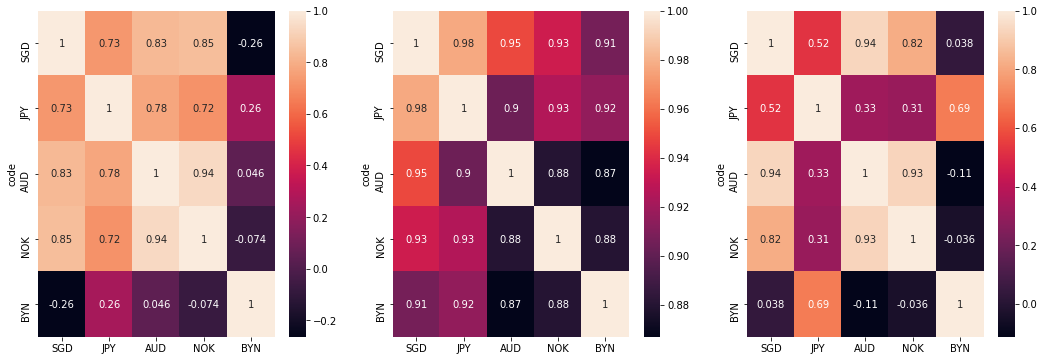

In [40]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

for i, index in enumerate(set(corr_df.index.get_level_values(0))):
    sns.heatmap(corr_df.loc[index], annot=True, ax=ax[i])

Чтобы все линии на графике были примерно на одного масштаба, домножим курсы на номиналы соответствующих валют


In [41]:
currency_df_nom = currency_df.copy()
for i in random_code:
    currency_df_nom.loc[:, i]*=int(currency_code[currency_code['ISO_char_code']==i].nominal.values)
currency_df_nom.head()

,date,SGD,JPY,AUD,NOK,BYN
0,2017-01-01,41.5887,51.1124,43.8799,70.131,30.5826
1,2017-01-02,41.5887,51.1124,43.8799,70.131,30.5826
2,2017-01-03,41.5887,51.1124,43.8799,70.131,30.5826
3,2017-01-04,41.5887,51.1124,43.8799,70.131,30.5826
4,2017-01-05,41.5887,51.1124,43.8799,70.131,30.5826


Построим график колебания валют за выбранный промежуток

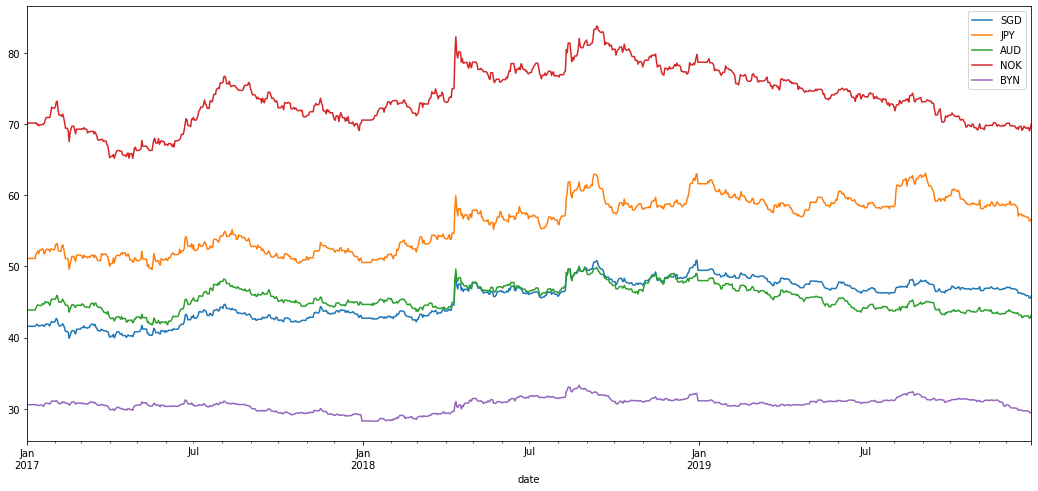

In [42]:
currency_df_nom.plot.line(x='date', figsize=(18,8))

* Из графика можно увидеть, что белорусский рубль весьма сильно связан с российским.
* Японская йена поднялась в цене по отношению к рублю.
* Сингапурский и австралийский доллары неплохо коррелируют между собой.
* Норвежская крона в 2019 году падала по отношению к рублю. Возможны курс норвежской кроны сильнее зависит от нефти, чем рубль.